In [1]:
import shap
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier, plot_importance
from sklearn.model_selection import train_test_split

## <font color='navy'> 1- Un xgboost

In [2]:
def histograma(probabilidades: np.ndarray, y_test: np):
    juntar = pd.DataFrame({
    'real': y_test,
    'probabilidades': probabilidades
    })
    plt.figure(figsize=(10, 5))
    plt.hist(juntar[juntar.real == 1]['probabilidades'], density=True, alpha=0.5, label = '1', color= 'skyblue')
    plt.hist(juntar[juntar.real == 0]['probabilidades'], density=True, alpha=0.5, label = '0', color = 'indianred')
    plt.title(f'Histograma de probabilidades de')
    plt.xlabel('Probabilidad')
    plt.ylabel('Densidad')
    plt.legend()
    plt.show()

### <font color='navy'> Datos

In [3]:
data = pd.read_csv('titanic.csv')
data = data.drop(columns=['PassengerId', 'Name', 'Ticket', 'Cabin'])
data.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,male,22.0,1,0,7.2500,S
1,1,1,female,38.0,1,0,71.2833,C
2,1,3,female,26.0,0,0,7.9250,S
3,1,1,female,35.0,1,0,53.1000,S
4,0,3,male,35.0,0,0,8.0500,S


In [4]:
data = pd.get_dummies(data)
#del data['Sex_female']
data.head()

,Survived,Pclass,Age,SibSp,Parch,Fare,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S
0,0,3,22.0,1,0,7.2500,False,True,False,False,True
1,1,1,38.0,1,0,71.2833,True,False,True,False,False
2,1,3,26.0,0,0,7.9250,True,False,False,False,True
3,1,1,35.0,1,0,53.1000,True,False,False,False,True
4,0,3,35.0,0,0,8.0500,False,True,False,False,True


In [5]:
target = 'Survived'
X = data.copy()
X = X.drop(columns=[target])
y = data[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### <font color='navy'> Modelo

In [6]:
model = XGBClassifier(
    n_estimators=200,
    learning_rate=0.1,
    max_depth=3,
    min_child_weight=1,
    subsample=0.8,
    colsample_bytree=0.8,
    n_jobs=-1,
    random_state=42,
    eval_metric='auc',
    early_stopping_rounds=50,
)

model.fit(X_train, y_train,
          eval_set=[(X_train, y_train), (X_test, y_test)],
          verbose=100)

[0]	validation_0-auc:0.83204	validation_1-auc:0.83764
[93]	validation_0-auc:0.93555	validation_1-auc:0.88739


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=50,
              enable_categorical=False, eval_metric='auc', feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=3,
              max_leaves=None, min_child_weight=1, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=200,
              n_jobs=-1, num_parallel_tree=None, ...)

### <font color='navy'> Resultados

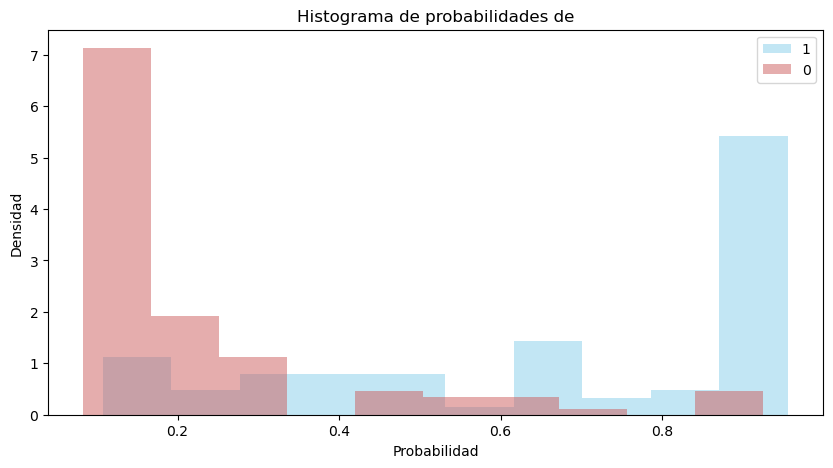

AUC: 0.8954


In [7]:
probabilidades = model.predict_proba(X_test)[:, 1]
histograma(probabilidades, y_test)
auc = roc_auc_score(y_test, probabilidades)
print(f'AUC: {auc:.4f}')

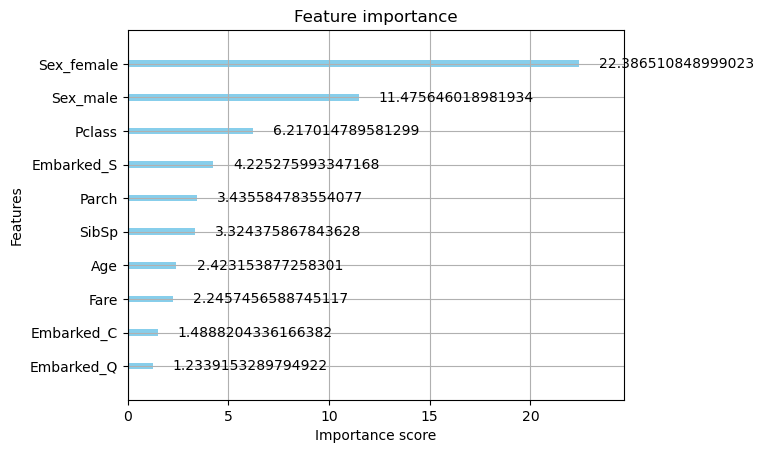

In [8]:
plot_importance(model, max_num_features=10, importance_type='gain', color = 'skyblue');

## <font color='navy'> 2- Shap values para una predicción en el conjunto de prueba 

In [9]:
# Sample
X_shap = X_test.sample(150, random_state=42)

# Inicializa los shaps explainer SHAP, shap.TreeExplainer
explainer = shap.TreeExplainer(model)

# explainer.shap_values
shap_values = explainer.shap_values(X_shap)

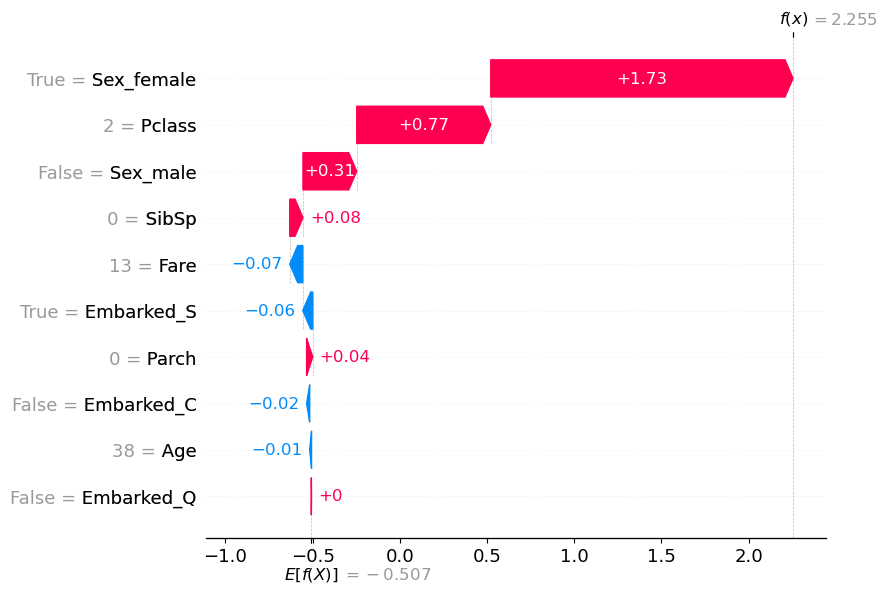

In [10]:
# Incicializa los shaps  initjs()
shap.initjs()

# Para visualizar shap individual con waterfall plot
n_dato = 0

# Visualiza el shap individual
shap.waterfall_plot(shap.Explanation(
        values=shap_values[n_dato],
        base_values=explainer.expected_value,
        data=X_shap.iloc[n_dato],
        feature_names=X_shap.columns
))

## <font color='navy'> 3- Shap values generales 

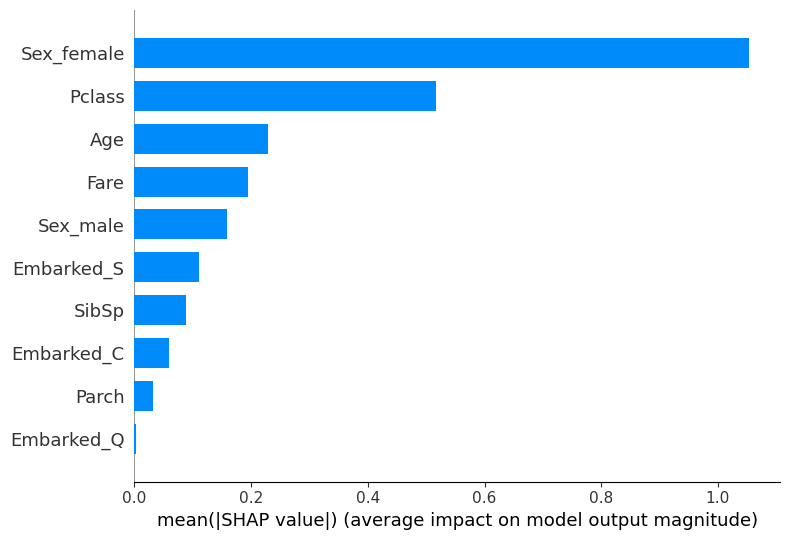

In [11]:
shap.summary_plot(shap_values, X_shap, plot_type="bar", max_display=10)

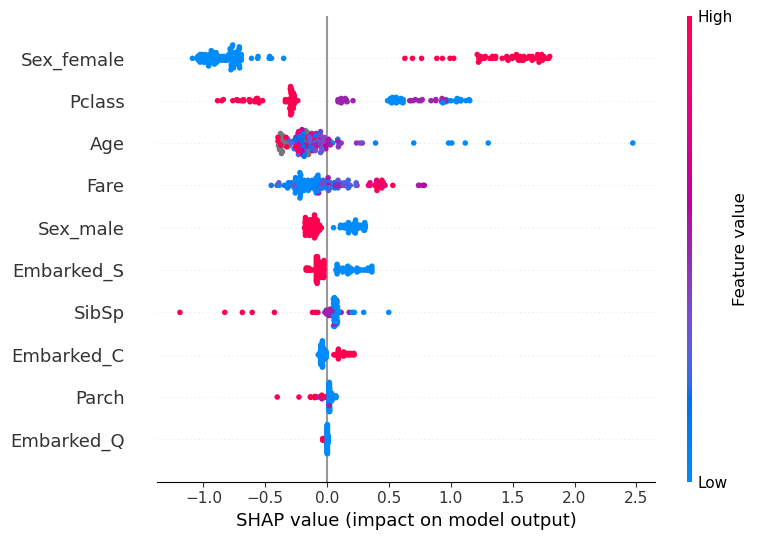

In [12]:
shap.summary_plot(shap_values, X_shap, plot_type="dot", max_display=10)

## <font color='navy'> KMeans y Método del codo, ¿cuantos clusters?

### <font color='navy'> Método del codo

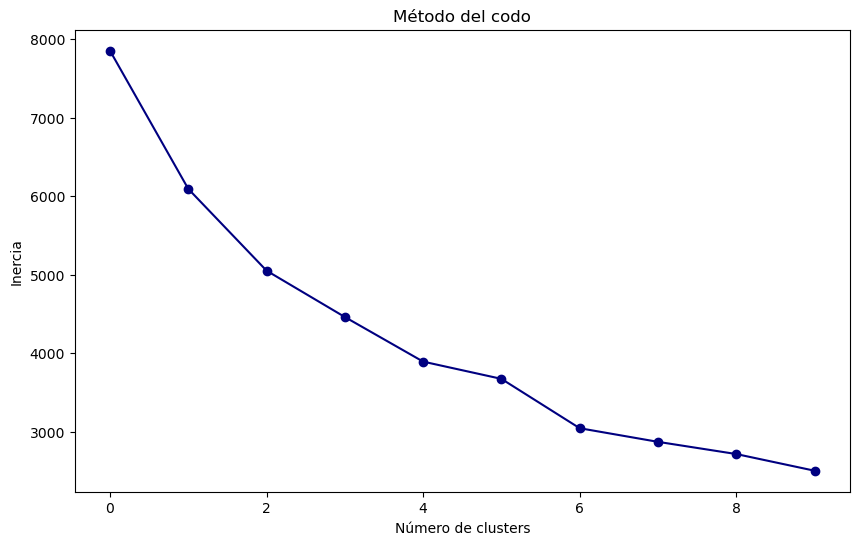

In [13]:
data.dropna(axis=0, inplace=True)

# Guarda la varianza del cluster o "inertia"
inertias = []

# ¿Cuantos clusters probar?
K_range = range(1, 11)
for i in K_range:
    pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('kmeans', KMeans(n_clusters=i, random_state=42))
    ])
    pipeline.fit(data)
    inertias.append(pipeline.named_steps['kmeans'].inertia_)

plt.figure(figsize=(10, 6))
plt.plot(inertias, marker = 'o', c = 'navy')
plt.title('Método del codo')
plt.xlabel('Número de clusters')
plt.ylabel('Inercia')
plt.show()

### <font color='navy'> KMeans

In [14]:
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('kmeans', KMeans(n_clusters=4, random_state=42))
])
pipeline.fit(data)

Pipeline(steps=[('scaler', StandardScaler()),
                ('kmeans', KMeans(n_clusters=4, random_state=42))])

In [15]:
data['cluster'] = pipeline.predict(data)

## <font color='navy'> 6- Dime las características generales del Cluster, puedes ver algo en particular? Puedes sacar el promedio de algunas variables y decirme si por ejempo la edad promedio en el cluster 1 es distinta a la del 2, si tiene más female, etc. 

In [16]:
pct = data.groupby('cluster').mean()
pct

,Survived,Pclass,Age,SibSp,Parch,Fare,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S
cluster,,,,,,,,,,,
0,0.777143,2.120000,28.822857,0.422857,0.480000,35.467858,1.000000,0.000000,0.0,0.062857,0.925714
1,0.352941,2.588235,14.194853,2.367647,2.102941,50.401715,0.367647,0.632353,0.0,0.073529,0.926471
2,0.607692,1.746154,30.814769,0.423077,0.415385,68.296767,0.469231,0.530769,1.0,0.000000,0.000000
3,0.149560,2.413490,32.815249,0.222874,0.079179,18.355166,0.000000,1.000000,0.0,0.035191,0.964809


In [17]:
values = data.groupby('cluster').sum()
values

,Survived,Pclass,Age,SibSp,Parch,Fare,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S
cluster,,,,,,,,,,,
0,136,371,5044.00,74,84,6206.8751,175,0,0,11,162
1,24,176,965.25,161,143,3427.3166,25,43,0,5,63
2,79,227,4005.92,55,54,8878.5797,61,69,130,0,0
3,51,823,11190.00,76,27,6259.1116,0,341,0,12,329
